# Load libraries

In [1]:
import cv2
import numpy as np
import pandas as pd

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.losses import binary_crossentropy
import keras.backend as K

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Define functions

In [2]:
def jaccard_coef(y_true, y_pred):
    y_true_fl = K.clip(K.batch_flatten(y_true), 0., 1.)
    y_pred_fl = K.clip(K.batch_flatten(y_pred), 0., 1.)
    y_true_fl = K.cast(K.greater(y_true_fl, 0.5), 'float32')
    y_pred_fl = K.cast(K.greater(y_pred_fl, 0.5), 'float32')
    intersection = K.sum(y_true_fl * y_pred_fl, axis=1)
    union = K.sum(K.maximum(y_true_fl, y_pred_fl), axis=1)
    union = K.switch(K.equal(union, 0), K.ones_like(union), union)
    return K.mean(intersection / K.cast(union, 'float32'))

def jaccard_coef_loss(y_true, y_pred):
    return -jaccard_coef(y_true, y_pred)

# Training

In [3]:
input_size = 224
max_epochs = 100
threshold  = 0.5

In [4]:
df_train = pd.read_csv('data2/data/train_masks.csv')

In [5]:
df_train.head()

img camera_short_name camera_long_name  counter  suspect eye  \
0  G-TPC0001-R.jpg               TPC           Topcon        1        1   R   
1  G-TPC0002-L.jpg               TPC           Topcon        2        1   L   
2  G-TPC0003-L.jpg               TPC           Topcon        3        1   L   
3  G-TPC0004-R.jpg               TPC           Topcon        4        1   R   
4  G-TPC0005-L.jpg               TPC           Topcon        5        1   L   

   height  width  areaDisc  saturationPixels  saturationLevel  scale  g  b  \
0    1934   1956     70095                 0                0   1081  1  1   
1    1934   1956     58620                 0                0   1081  1  1   
2    1934   1956     58703              1100                0   1081  1  1   
3    1934   1956     59826                 0                0   1081  1  1   
4    1934   1956     50247                 0                0   1081  1  1   

   factor      M   P      C  
0  0.9985  64.52  18  62.85  
1  0.9985  64.52  18  62.85  
2  0.9985  64.52  18  62.85  
3  0.9985  64.52  18  62.85  
4  0.9985  64.52  18  62.85

In [6]:
ids_train = df_train['img'].map(lambda s: s.split('.')[0])

In [7]:
ids_train_split, ids_valid_split = train_test_split(ids_train, test_size=0.2, random_state=42)

In [8]:
def randomHueSaturationValue(image, hue_shift_limit=(-180, 180),
                             sat_shift_limit=(-255, 255),
                             val_shift_limit=(-255, 255), u=0.5):
    if np.random.random() < u:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(image)
        hue_shift = np.random.uniform(hue_shift_limit[0], hue_shift_limit[1])
        h = cv2.add(h, hue_shift)
        sat_shift = np.random.uniform(sat_shift_limit[0], sat_shift_limit[1])
        s = cv2.add(s, sat_shift)
        val_shift = np.random.uniform(val_shift_limit[0], val_shift_limit[1])
        v = cv2.add(v, val_shift)
        image = cv2.merge((h, s, v))
        image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)

    return image

In [9]:
def randomShiftScaleRotate(image, mask,
                           shift_limit=(-0.0625, 0.0625),
                           scale_limit=(-0.1, 0.1),
                           rotate_limit=(-45, 45), aspect_limit=(0, 0),
                           borderMode=cv2.BORDER_CONSTANT, u=0.5):
    if np.random.random() < u:
        height, width, channel = image.shape

        angle = np.random.uniform(rotate_limit[0], rotate_limit[1])  # degree
        scale = np.random.uniform(1 + scale_limit[0], 1 + scale_limit[1])
        aspect = np.random.uniform(1 + aspect_limit[0], 1 + aspect_limit[1])
        sx = scale * aspect / (aspect ** 0.5)
        sy = scale / (aspect ** 0.5)
        dx = round(np.random.uniform(shift_limit[0], shift_limit[1]) * width)
        dy = round(np.random.uniform(shift_limit[0], shift_limit[1]) * height)

        cc = np.math.cos(angle / 180 * np.math.pi) * sx
        ss = np.math.sin(angle / 180 * np.math.pi) * sy
        rotate_matrix = np.array([[cc, -ss], [ss, cc]])

        box0 = np.array([[0, 0], [width, 0], [width, height], [0, height], ])
        box1 = box0 - np.array([width / 2, height / 2])
        box1 = np.dot(box1, rotate_matrix.T) + np.array([width / 2 + dx, height / 2 + dy])

        box0 = box0.astype(np.float32)
        box1 = box1.astype(np.float32)
        mat = cv2.getPerspectiveTransform(box0, box1)
        image = cv2.warpPerspective(image, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                    borderValue=(
                                        0, 0,
                                        0,))
        mask = cv2.warpPerspective(mask, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                   borderValue=(
                                       0, 0,
                                       0,))

    return image, mask


In [10]:
def randomHorizontalFlip(image, mask, u=0.5):
    if np.random.random() < u:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)

    return image, mask


In [11]:
all_imgs  = {}
all_masks = {}
for id in ids_train:
    img  = cv2.imread('data2/data/train/{}.jpg'.format(id))
    img  = cv2.resize(img, (input_size, input_size))
    mask = cv2.imread('data2/data/train_masks/{}_mask.png'.format(id), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (input_size, input_size))
    all_imgs[id]  = img
    all_masks[id] = mask

In [12]:
import random

In [13]:
def train_generator(train_batch_size):
    while True:
        this_ids_train_split = random.sample(list(ids_train_split), len(ids_train_split))
        for start in range(0, len(ids_train_split), train_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + train_batch_size, len(ids_train_split))
            ids_train_batch = this_ids_train_split[start:end]
            for id in ids_train_batch:
                img  = all_imgs[id]
                mask = all_masks[id]
                img = randomHueSaturationValue(img,
                                               hue_shift_limit=(-50, 50),
                                               sat_shift_limit=(-5, 5),
                                               val_shift_limit=(-15, 15))
                img, mask = randomShiftScaleRotate(img, mask,
                                                   shift_limit=(-0.0625, 0.0625),
                                                   scale_limit=(-0.1, 0.1),
                                                   rotate_limit=(-0, 0))
                img, mask = randomHorizontalFlip(img, mask)
                mask = np.expand_dims(mask, axis=2)
                x_batch.append(img)
                y_batch.append(mask)
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            yield x_batch, y_batch


In [14]:
def valid_generator(val_batch_size):
    while True:
        for start in range(0, len(ids_valid_split), val_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + val_batch_size, len(ids_valid_split))
            ids_valid_batch = ids_valid_split[start:end]
            for id in ids_valid_batch.values:
                img  = all_imgs[id]
                mask = all_masks[id]
                mask = np.expand_dims(mask, axis=2)
                x_batch.append(img)
                y_batch.append(mask)
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            yield x_batch, y_batch



In [15]:
train_batch_size = 3
val_batch_size   = 8

In [16]:
from zf_unet_224_model import ZF_UNET_224, dice_coef_loss, dice_coef
from keras.optimizers import Adam

model = ZF_UNET_224(weights='generator')
optim = Adam()
model.compile(optimizer=optim, loss=dice_coef_loss, metrics=[dice_coef, dice_coef_loss, jaccard_coef])

callbacks = [ModelCheckpoint(monitor='val_dice_coef_loss',
                             filepath='weights/best_zf_unet_224.h5',
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max')]


history = model.fit_generator(generator=train_generator(train_batch_size),
                    steps_per_epoch=np.ceil(float(len(ids_train_split)) / float(train_batch_size)),
                    epochs=max_epochs,
                    verbose=2,
                    callbacks=callbacks,
                    validation_data=valid_generator(val_batch_size),
                    validation_steps=np.ceil(float(len(ids_valid_split)) / float(val_batch_size)))

Epoch 1/100
 - 30s - loss: -5.9735e-01 - dice_coef: 0.5974 - dice_coef_loss: -5.9735e-01 - jaccard_coef: 0.4639 - val_loss: -6.9159e-01 - val_dice_coef: 0.6916 - val_dice_coef_loss: -6.9159e-01 - val_jaccard_coef: 0.5186
Epoch 2/100
 - 24s - loss: -7.9774e-01 - dice_coef: 0.7977 - dice_coef_loss: -7.9774e-01 - jaccard_coef: 0.6770 - val_loss: -8.1264e-01 - val_dice_coef: 0.8126 - val_dice_coef_loss: -8.1264e-01 - val_jaccard_coef: 0.6940
Epoch 3/100
 - 24s - loss: -8.4531e-01 - dice_coef: 0.8453 - dice_coef_loss: -8.4531e-01 - jaccard_coef: 0.7440 - val_loss: -8.4717e-01 - val_dice_coef: 0.8472 - val_dice_coef_loss: -8.4717e-01 - val_jaccard_coef: 0.7415
Epoch 4/100
 - 24s - loss: -8.6684e-01 - dice_coef: 0.8668 - dice_coef_loss: -8.6684e-01 - jaccard_coef: 0.7755 - val_loss: -8.9071e-01 - val_dice_coef: 0.8907 - val_dice_coef_loss: -8.9071e-01 - val_jaccard_coef: 0.8063
Epoch 5/100
 - 24s - loss: -8.8244e-01 - dice_coef: 0.8824 - dice_coef_loss: -8.8244e-01 - jaccard_coef: 0.7992 - va

Epoch 38/100
 - 24s - loss: -9.3945e-01 - dice_coef: 0.9394 - dice_coef_loss: -9.3945e-01 - jaccard_coef: 0.8900 - val_loss: -9.3720e-01 - val_dice_coef: 0.9372 - val_dice_coef_loss: -9.3720e-01 - val_jaccard_coef: 0.8813
Epoch 39/100
 - 24s - loss: -9.4026e-01 - dice_coef: 0.9403 - dice_coef_loss: -9.4026e-01 - jaccard_coef: 0.8911 - val_loss: -9.4115e-01 - val_dice_coef: 0.9412 - val_dice_coef_loss: -9.4115e-01 - val_jaccard_coef: 0.8886
Epoch 40/100
 - 24s - loss: -9.4308e-01 - dice_coef: 0.9431 - dice_coef_loss: -9.4308e-01 - jaccard_coef: 0.8957 - val_loss: -9.4557e-01 - val_dice_coef: 0.9456 - val_dice_coef_loss: -9.4557e-01 - val_jaccard_coef: 0.8966
Epoch 41/100
 - 24s - loss: -9.4405e-01 - dice_coef: 0.9441 - dice_coef_loss: -9.4405e-01 - jaccard_coef: 0.8984 - val_loss: -9.4725e-01 - val_dice_coef: 0.9472 - val_dice_coef_loss: -9.4725e-01 - val_jaccard_coef: 0.8993
Epoch 42/100
 - 24s - loss: -9.4468e-01 - dice_coef: 0.9447 - dice_coef_loss: -9.4468e-01 - jaccard_coef: 0.8986

Epoch 75/100
 - 24s - loss: -9.4902e-01 - dice_coef: 0.9490 - dice_coef_loss: -9.4902e-01 - jaccard_coef: 0.9068 - val_loss: -9.5156e-01 - val_dice_coef: 0.9516 - val_dice_coef_loss: -9.5156e-01 - val_jaccard_coef: 0.9070
Epoch 76/100
 - 24s - loss: -9.5023e-01 - dice_coef: 0.9502 - dice_coef_loss: -9.5023e-01 - jaccard_coef: 0.9089 - val_loss: -9.4871e-01 - val_dice_coef: 0.9487 - val_dice_coef_loss: -9.4871e-01 - val_jaccard_coef: 0.9027
Epoch 77/100
 - 24s - loss: -9.5095e-01 - dice_coef: 0.9509 - dice_coef_loss: -9.5095e-01 - jaccard_coef: 0.9102 - val_loss: -9.4773e-01 - val_dice_coef: 0.9477 - val_dice_coef_loss: -9.4773e-01 - val_jaccard_coef: 0.9000
Epoch 78/100
 - 24s - loss: -9.5054e-01 - dice_coef: 0.9505 - dice_coef_loss: -9.5054e-01 - jaccard_coef: 0.9098 - val_loss: -9.4957e-01 - val_dice_coef: 0.9496 - val_dice_coef_loss: -9.4957e-01 - val_jaccard_coef: 0.9040
Epoch 79/100
 - 24s - loss: -9.5188e-01 - dice_coef: 0.9519 - dice_coef_loss: -9.5188e-01 - jaccard_coef: 0.9121

In [17]:
history.history

{'val_loss': [-0.691585320631663,
  -0.8126357626914978,
  -0.8471671565373738,
  -0.8907128802935282,
  -0.9016190854708354,
  -0.8852467656135559,
  -0.9033212685585021,
  -0.923337721824646,
  -0.9212943045298259,
  -0.9261764732996622,
  -0.9261338726679484,
  -0.9225829799969991,
  -0.9256927299499512,
  -0.9354182410240174,
  -0.9343472719192505,
  -0.9362096476554871,
  -0.9307687322298686,
  -0.9227047332127889,
  -0.9317535042762757,
  -0.9380787897109986,
  -0.9143335096041362,
  -0.8057469383875528,
  -0.9410854832331339,
  -0.9306986292203268,
  -0.94215980052948,
  -0.9427691491444906,
  -0.9421121104558309,
  -0.9400920136769613,
  -0.9409113176663717,
  -0.9415819772084554,
  -0.9388886531194051,
  -0.9332118654251098,
  -0.9306276631355286,
  -0.9394560209910074,
  -0.9458886988957723,
  -0.9297154990832011,
  -0.9453258466720581,
  -0.9372011748949687,
  -0.9411504284540813,
  -0.9455733982721964,
  -0.947246630191803,
  -0.9452247373263041,
  -0.9420653438568115,
  -0

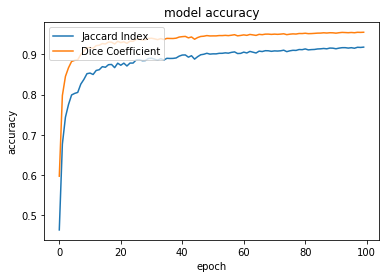

In [18]:
plt.plot(history.history['jaccard_coef'])
plt.plot(history.history['dice_coef'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Jaccard Index', 'Dice Coefficient'], loc='upper left')
plt.show()

In [19]:
from keras.utils import plot_model  
plot_model(model, to_file='model-zf_224.png', show_shapes=True, show_layer_names=True)  
from IPython.display import FileLink
FileLink('model-zf_224.png')

/home/ubuntu/workspace/Fundus_UNET/model-zf_224.png

# Predictions

In [20]:
from tqdm import tqdm

In [21]:
df_test = pd.read_csv('data2/data/test.csv')
ids_test = df_test['img'].map(lambda s: s.split('.')[0])

In [22]:
names = []
for id in ids_test:
    names.append('{}.jpg'.format(id))

In [23]:
model.load_weights(filepath='weights/best_zf_unet_224.h5')

In [24]:
val_batch_size = 1

  0%|          | 0/265 [00:00<?, ?it/s]

Predicting on 265 samples with batch_size = 1...


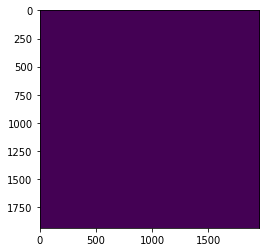

  0%|          | 1/265 [00:00<04:06,  1.07it/s]

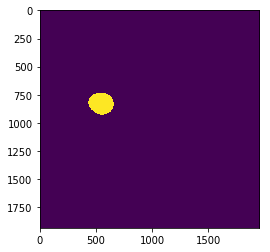

  1%|          | 2/265 [00:01<02:36,  1.68it/s]

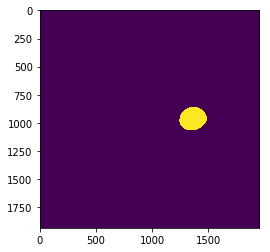

  1%|          | 3/265 [00:01<02:06,  2.07it/s]

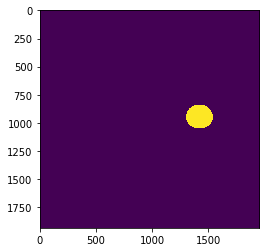

  2%|▏         | 4/265 [00:01<01:51,  2.33it/s]

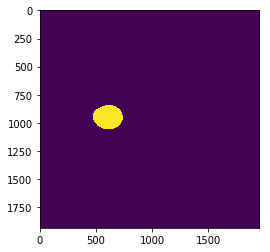

  2%|▏         | 5/265 [00:01<01:42,  2.53it/s]

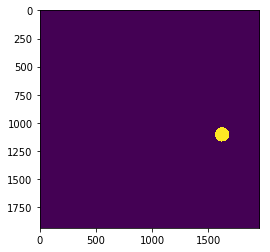

  2%|▏         | 6/265 [00:02<01:36,  2.68it/s]

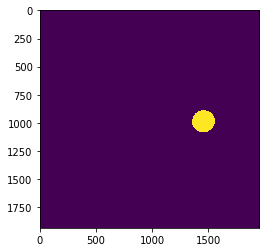

  3%|▎         | 7/265 [00:02<01:32,  2.79it/s]

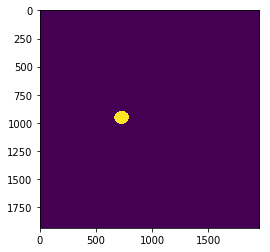

  3%|▎         | 8/265 [00:02<01:28,  2.89it/s]

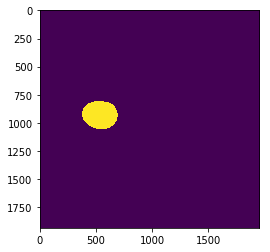

  3%|▎         | 9/265 [00:03<01:26,  2.97it/s]

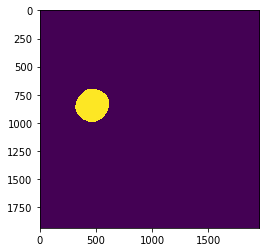

  4%|▍         | 10/265 [00:03<01:24,  3.02it/s]

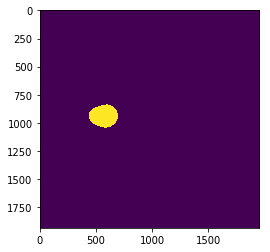

  4%|▍         | 11/265 [00:03<01:22,  3.08it/s]

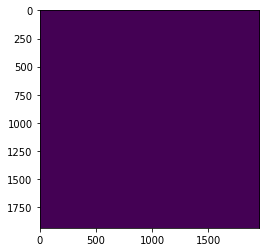

  5%|▍         | 12/265 [00:03<01:21,  3.12it/s]

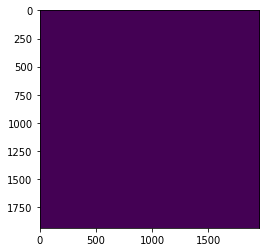

  5%|▍         | 13/265 [00:04<01:19,  3.16it/s]

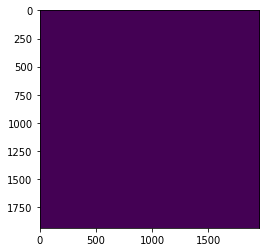

  5%|▌         | 14/265 [00:04<01:18,  3.20it/s]

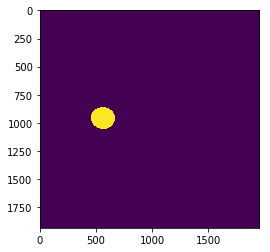

  6%|▌         | 15/265 [00:04<01:17,  3.23it/s]

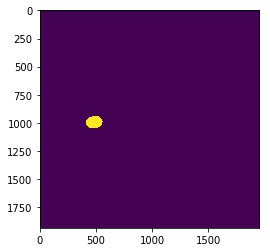

  6%|▌         | 16/265 [00:04<01:16,  3.26it/s]

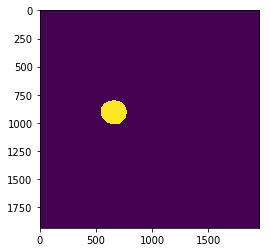

  6%|▋         | 17/265 [00:05<01:15,  3.29it/s]

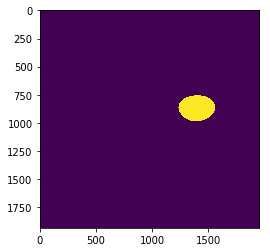

  7%|▋         | 18/265 [00:05<01:14,  3.32it/s]

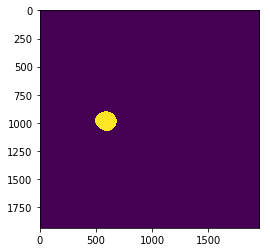

  7%|▋         | 19/265 [00:05<01:13,  3.34it/s]

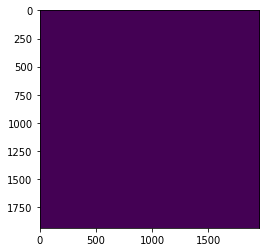

  8%|▊         | 20/265 [00:05<01:13,  3.35it/s]

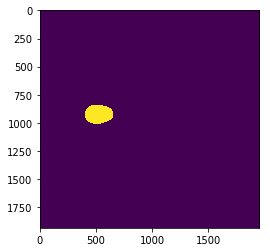

  8%|▊         | 21/265 [00:06<01:12,  3.37it/s]

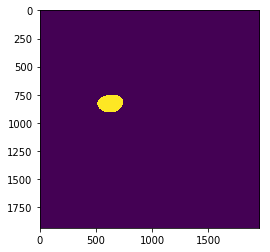

  8%|▊         | 22/265 [00:06<01:11,  3.39it/s]

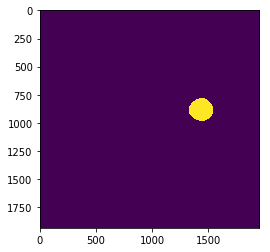

  9%|▊         | 23/265 [00:06<01:11,  3.41it/s]

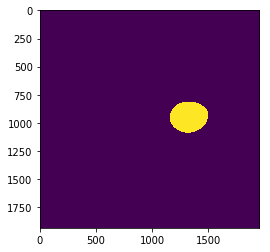

  9%|▉         | 24/265 [00:07<01:10,  3.42it/s]

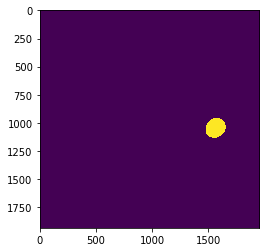

  9%|▉         | 25/265 [00:07<01:09,  3.43it/s]

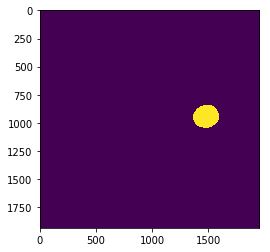

 10%|▉         | 26/265 [00:07<01:09,  3.44it/s]

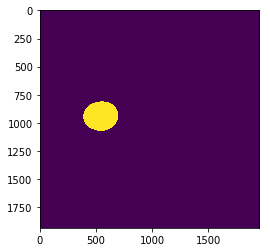

 10%|█         | 27/265 [00:07<01:08,  3.45it/s]

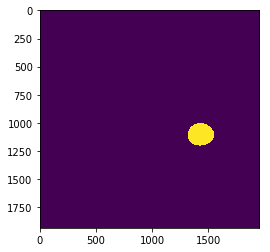

 11%|█         | 28/265 [00:08<01:08,  3.46it/s]

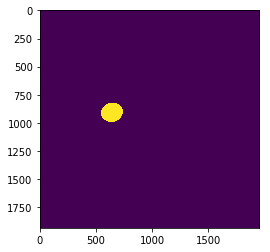

 11%|█         | 29/265 [00:08<01:07,  3.47it/s]

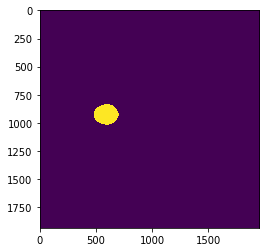

 11%|█▏        | 30/265 [00:08<01:07,  3.48it/s]

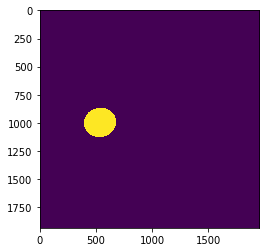

 12%|█▏        | 31/265 [00:08<01:07,  3.49it/s]

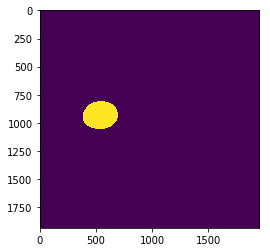

 12%|█▏        | 32/265 [00:09<01:06,  3.50it/s]

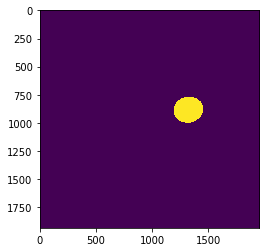

 12%|█▏        | 33/265 [00:09<01:06,  3.51it/s]

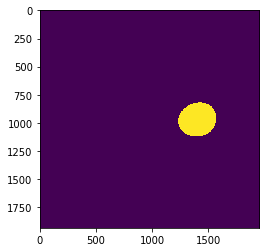

 13%|█▎        | 34/265 [00:09<01:05,  3.51it/s]

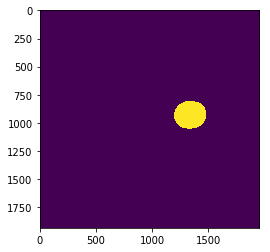

 13%|█▎        | 35/265 [00:09<01:05,  3.52it/s]

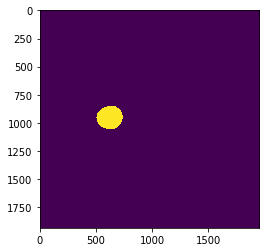

 14%|█▎        | 36/265 [00:10<01:04,  3.53it/s]

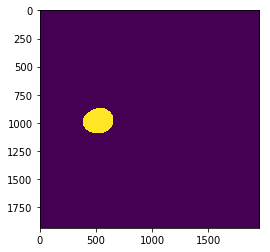

 14%|█▍        | 37/265 [00:10<01:04,  3.53it/s]

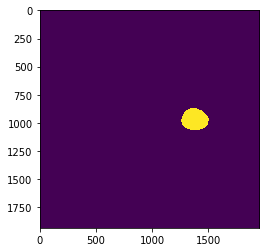

 14%|█▍        | 38/265 [00:10<01:04,  3.54it/s]

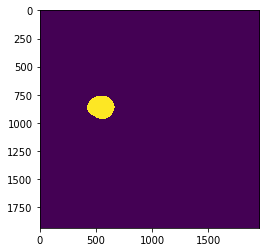

 15%|█▍        | 39/265 [00:11<01:03,  3.54it/s]

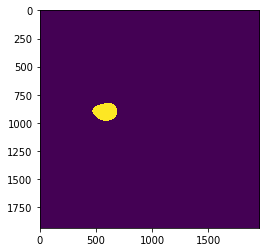

 15%|█▌        | 40/265 [00:11<01:03,  3.55it/s]

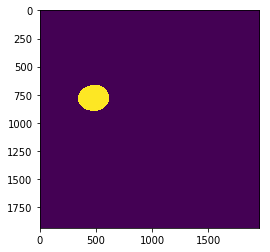

 15%|█▌        | 41/265 [00:11<01:02,  3.56it/s]

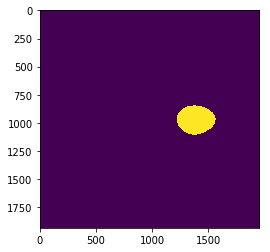

 16%|█▌        | 42/265 [00:11<01:02,  3.56it/s]

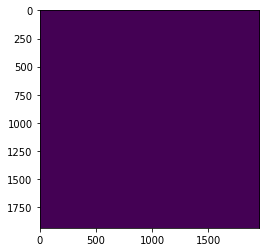

 16%|█▌        | 43/265 [00:12<01:02,  3.57it/s]

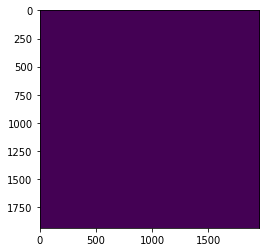

 17%|█▋        | 44/265 [00:12<01:01,  3.57it/s]

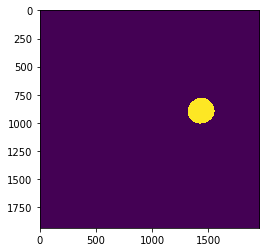

 17%|█▋        | 45/265 [00:12<01:01,  3.56it/s]

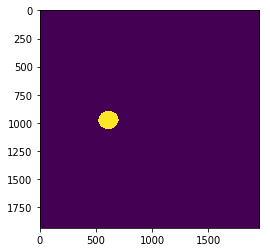

 17%|█▋        | 46/265 [00:12<01:01,  3.56it/s]

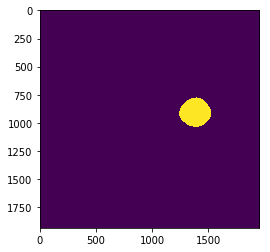

 18%|█▊        | 47/265 [00:13<01:01,  3.57it/s]

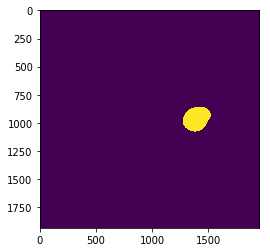

 18%|█▊        | 48/265 [00:13<01:00,  3.57it/s]

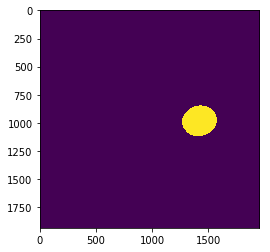

 18%|█▊        | 49/265 [00:13<01:00,  3.58it/s]

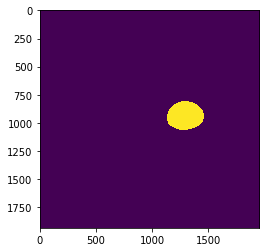

 19%|█▉        | 50/265 [00:13<01:00,  3.58it/s]

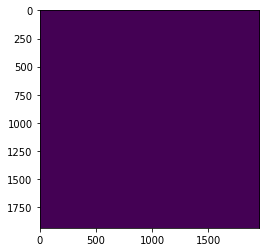

 19%|█▉        | 51/265 [00:14<00:59,  3.58it/s]

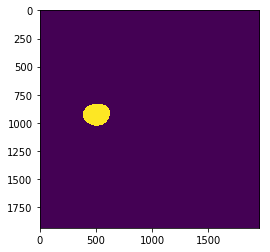

 20%|█▉        | 52/265 [00:14<00:59,  3.59it/s]

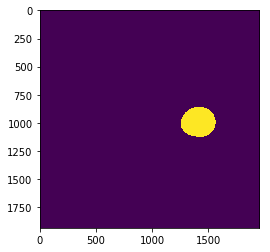

 20%|██        | 53/265 [00:14<00:59,  3.59it/s]

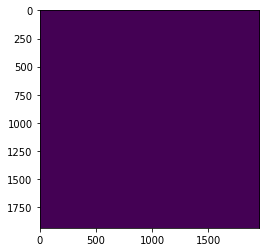

 20%|██        | 54/265 [00:15<00:58,  3.59it/s]

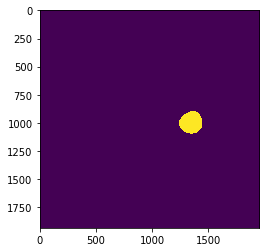

 21%|██        | 55/265 [00:15<00:58,  3.60it/s]

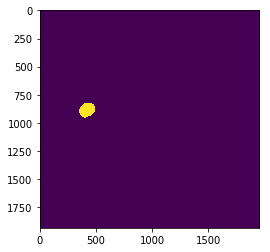

 21%|██        | 56/265 [00:15<00:58,  3.60it/s]

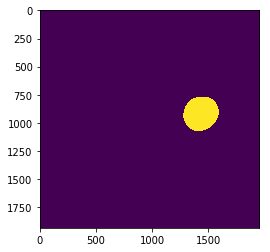

 22%|██▏       | 57/265 [00:15<00:57,  3.60it/s]

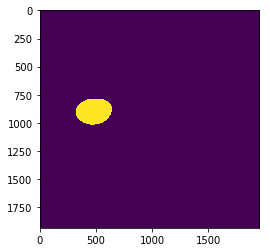

 22%|██▏       | 58/265 [00:16<00:57,  3.60it/s]

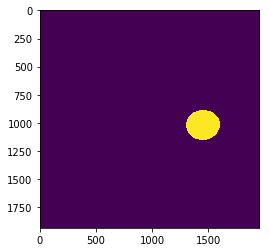

 22%|██▏       | 59/265 [00:16<00:57,  3.60it/s]

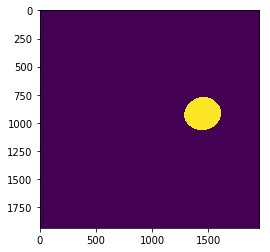

 23%|██▎       | 60/265 [00:16<00:56,  3.60it/s]

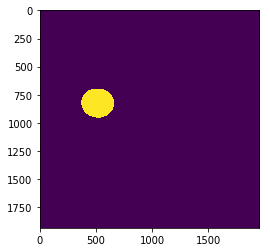

 23%|██▎       | 61/265 [00:16<00:56,  3.61it/s]

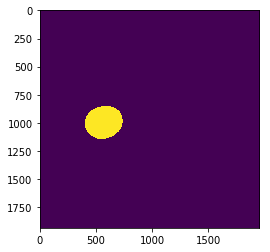

 23%|██▎       | 62/265 [00:17<00:56,  3.61it/s]

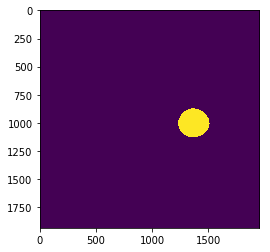

 24%|██▍       | 63/265 [00:17<00:56,  3.57it/s]

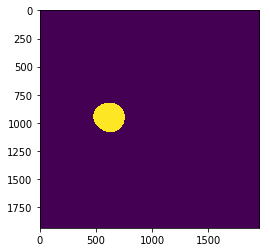

 24%|██▍       | 64/265 [00:17<00:56,  3.58it/s]

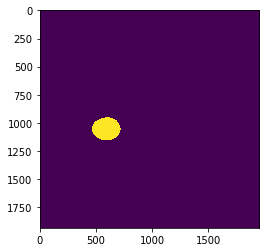

 25%|██▍       | 65/265 [00:18<00:55,  3.58it/s]

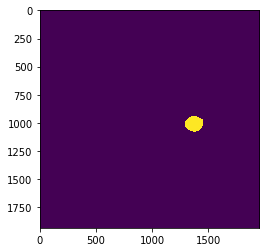

 25%|██▍       | 66/265 [00:18<00:55,  3.58it/s]

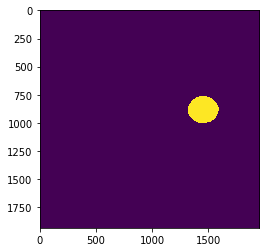

 25%|██▌       | 67/265 [00:18<00:55,  3.59it/s]

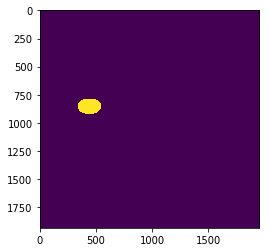

 26%|██▌       | 68/265 [00:18<00:54,  3.59it/s]

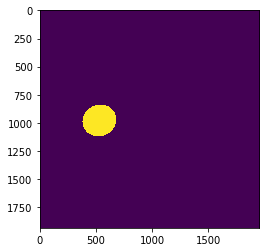

 26%|██▌       | 69/265 [00:19<00:54,  3.60it/s]

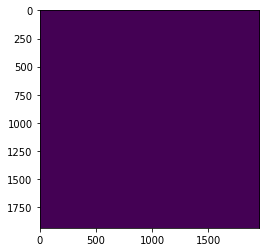

 26%|██▋       | 70/265 [00:19<00:54,  3.60it/s]

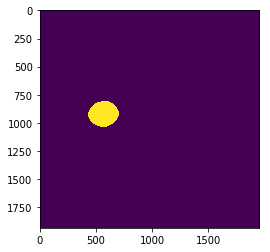

 27%|██▋       | 71/265 [00:19<00:53,  3.60it/s]

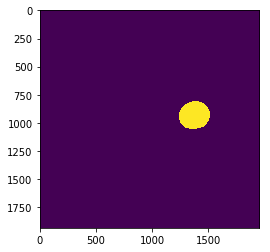

 27%|██▋       | 72/265 [00:19<00:53,  3.61it/s]

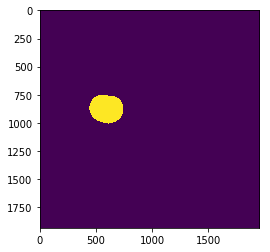

 28%|██▊       | 73/265 [00:20<00:53,  3.61it/s]

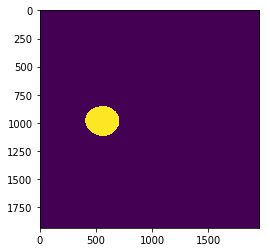

 28%|██▊       | 74/265 [00:20<00:52,  3.61it/s]

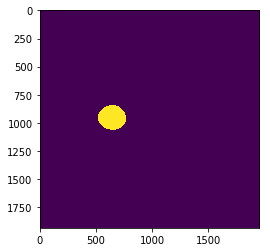

 28%|██▊       | 75/265 [00:20<00:52,  3.62it/s]

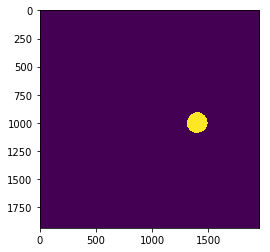

 29%|██▊       | 76/265 [00:20<00:52,  3.62it/s]

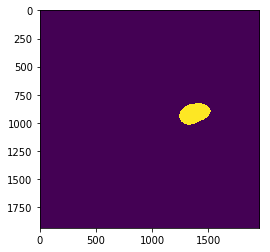

 29%|██▉       | 77/265 [00:21<00:51,  3.62it/s]

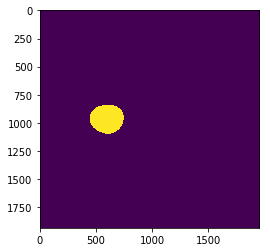

 29%|██▉       | 78/265 [00:21<00:51,  3.61it/s]

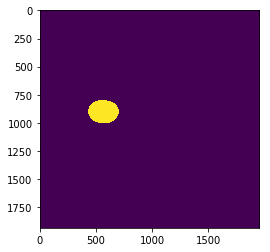

 30%|██▉       | 79/265 [00:21<00:51,  3.61it/s]

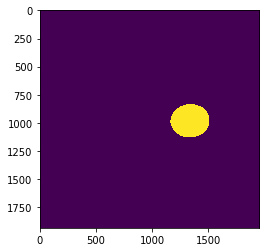

 30%|███       | 80/265 [00:22<00:51,  3.60it/s]

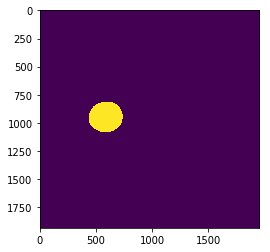

 31%|███       | 81/265 [00:22<00:51,  3.60it/s]

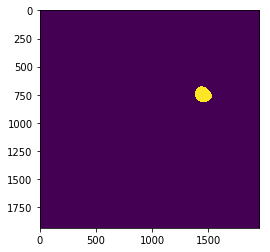

 31%|███       | 82/265 [00:22<00:50,  3.61it/s]

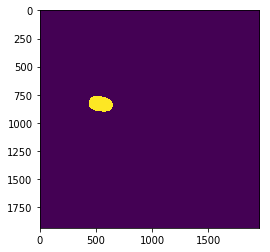

 31%|███▏      | 83/265 [00:23<00:50,  3.60it/s]

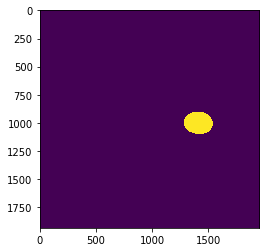

 32%|███▏      | 84/265 [00:23<00:50,  3.60it/s]

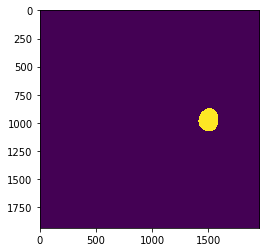

 32%|███▏      | 85/265 [00:23<00:50,  3.60it/s]

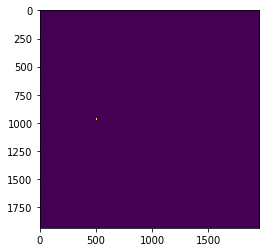

 32%|███▏      | 86/265 [00:23<00:49,  3.60it/s]

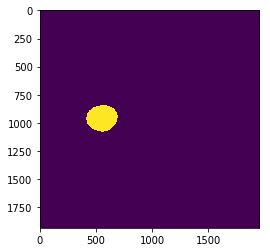

 33%|███▎      | 87/265 [00:24<00:49,  3.60it/s]

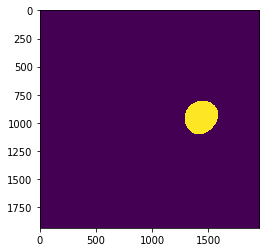

 33%|███▎      | 88/265 [00:24<00:49,  3.61it/s]

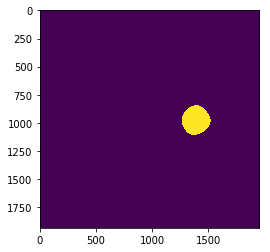

 34%|███▎      | 89/265 [00:24<00:48,  3.61it/s]

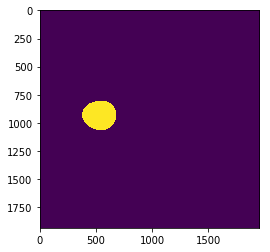

 34%|███▍      | 90/265 [00:24<00:48,  3.61it/s]

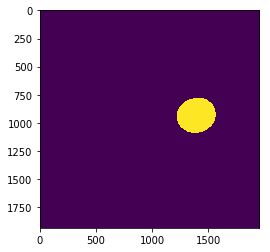

 34%|███▍      | 91/265 [00:25<00:48,  3.61it/s]

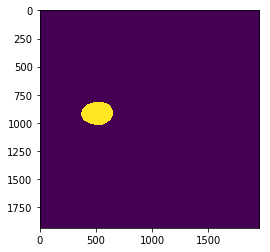

 35%|███▍      | 92/265 [00:25<00:47,  3.61it/s]

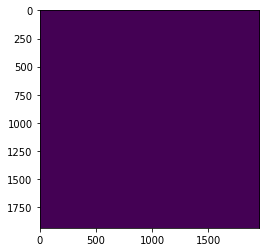

 35%|███▌      | 93/265 [00:25<00:47,  3.62it/s]

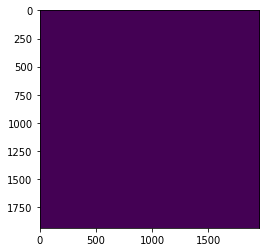

 35%|███▌      | 94/265 [00:26<00:47,  3.61it/s]

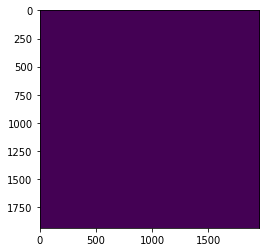

 36%|███▌      | 95/265 [00:26<00:47,  3.61it/s]

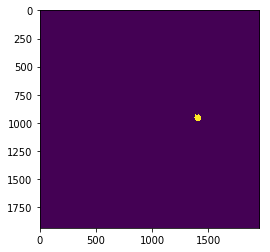

 36%|███▌      | 96/265 [00:26<00:46,  3.61it/s]

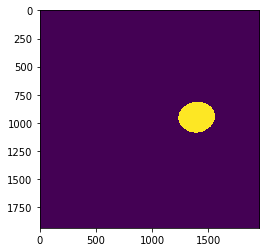

 37%|███▋      | 97/265 [00:26<00:46,  3.61it/s]

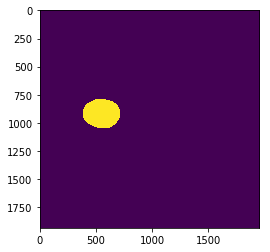

 37%|███▋      | 98/265 [00:27<00:46,  3.62it/s]

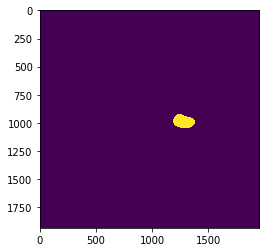

 37%|███▋      | 99/265 [00:27<00:45,  3.62it/s]

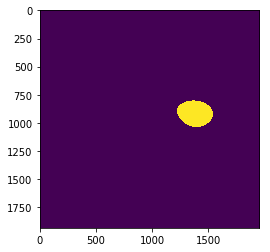

 38%|███▊      | 100/265 [00:27<00:45,  3.62it/s]

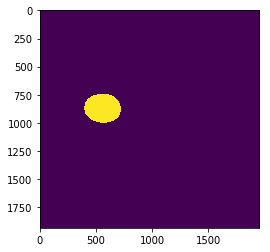

 38%|███▊      | 101/265 [00:27<00:45,  3.62it/s]

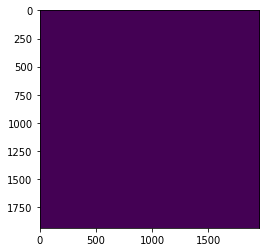

 38%|███▊      | 102/265 [00:28<00:44,  3.63it/s]

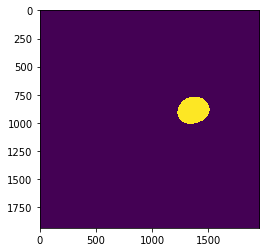

 39%|███▉      | 103/265 [00:28<00:44,  3.63it/s]

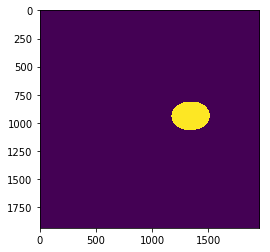

 39%|███▉      | 104/265 [00:28<00:44,  3.63it/s]

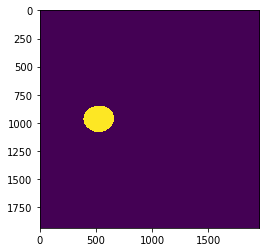

 40%|███▉      | 105/265 [00:28<00:44,  3.63it/s]

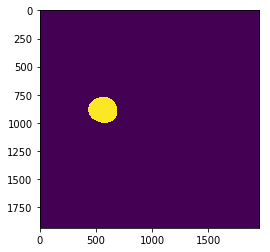

 40%|████      | 106/265 [00:29<00:43,  3.64it/s]

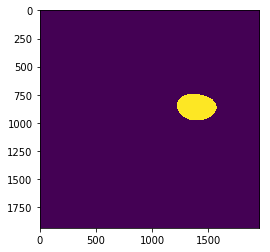

 40%|████      | 107/265 [00:29<00:43,  3.64it/s]

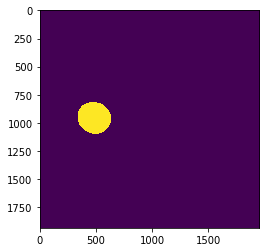

 41%|████      | 108/265 [00:29<00:43,  3.64it/s]

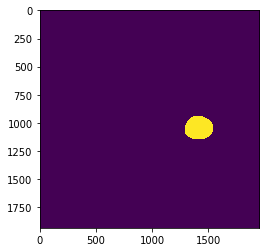

 41%|████      | 109/265 [00:29<00:42,  3.64it/s]

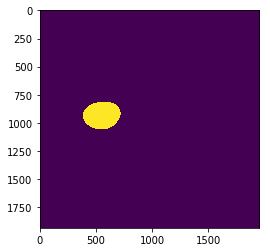

 42%|████▏     | 110/265 [00:30<00:42,  3.65it/s]

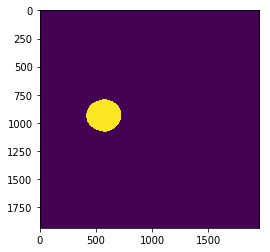

 42%|████▏     | 111/265 [00:30<00:42,  3.65it/s]

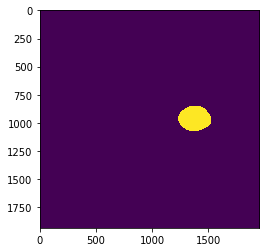

 42%|████▏     | 112/265 [00:30<00:41,  3.65it/s]

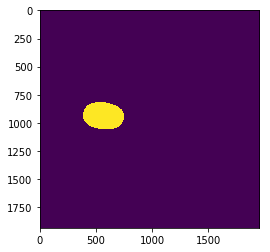

 43%|████▎     | 113/265 [00:30<00:41,  3.65it/s]

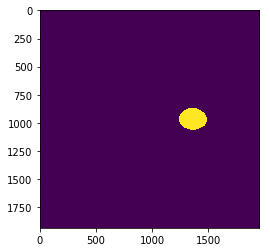

 43%|████▎     | 114/265 [00:31<00:41,  3.65it/s]

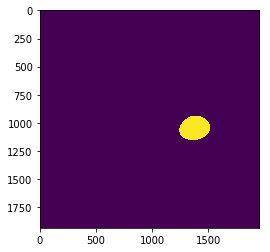

 43%|████▎     | 115/265 [00:31<00:41,  3.66it/s]

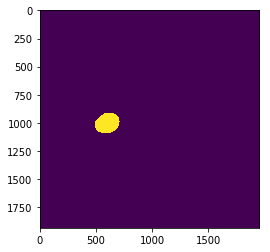

 44%|████▍     | 116/265 [00:31<00:40,  3.66it/s]

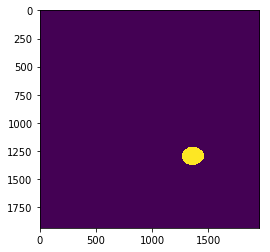

 44%|████▍     | 117/265 [00:31<00:40,  3.66it/s]

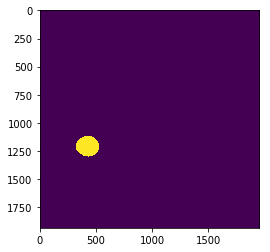

 45%|████▍     | 118/265 [00:32<00:40,  3.66it/s]

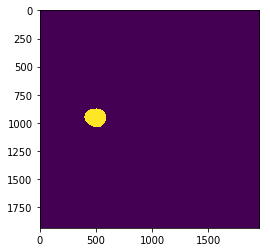

 45%|████▍     | 119/265 [00:32<00:39,  3.66it/s]

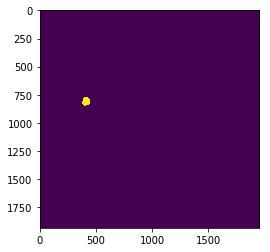

 45%|████▌     | 120/265 [00:32<00:39,  3.67it/s]

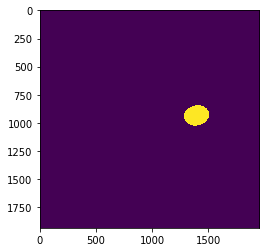

 46%|████▌     | 121/265 [00:32<00:39,  3.67it/s]

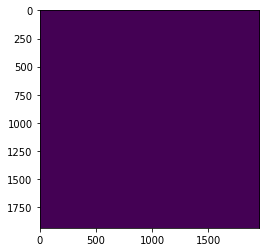

 46%|████▌     | 122/265 [00:33<00:38,  3.67it/s]

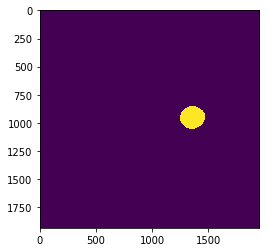

 46%|████▋     | 123/265 [00:33<00:38,  3.67it/s]

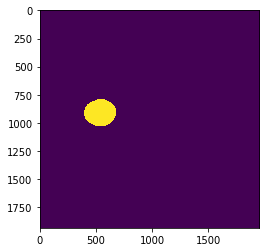

 47%|████▋     | 124/265 [00:33<00:38,  3.67it/s]

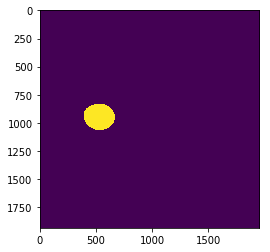

 47%|████▋     | 125/265 [00:34<00:38,  3.67it/s]

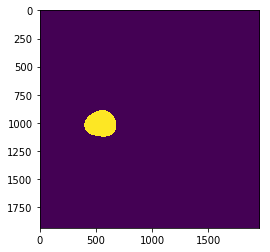

 48%|████▊     | 126/265 [00:34<00:37,  3.67it/s]

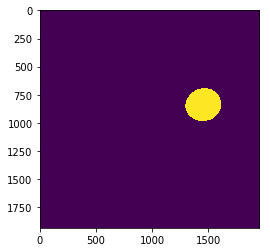

 48%|████▊     | 127/265 [00:34<00:37,  3.67it/s]

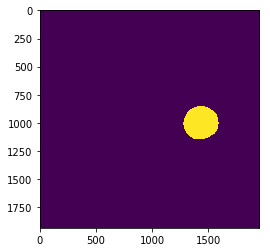

 48%|████▊     | 128/265 [00:34<00:37,  3.68it/s]

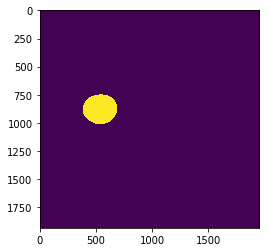

 49%|████▊     | 129/265 [00:35<00:36,  3.68it/s]

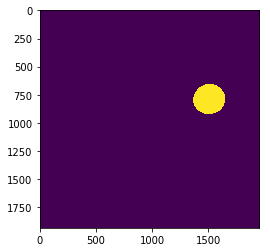

 49%|████▉     | 130/265 [00:35<00:36,  3.68it/s]

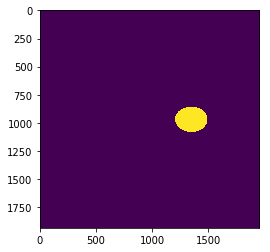

 49%|████▉     | 131/265 [00:35<00:36,  3.68it/s]

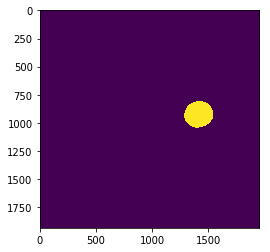

 50%|████▉     | 132/265 [00:35<00:36,  3.68it/s]

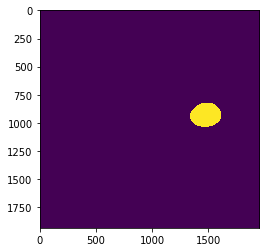

 50%|█████     | 133/265 [00:36<00:35,  3.68it/s]

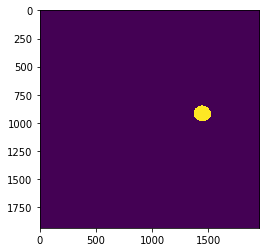

 51%|█████     | 134/265 [00:36<00:35,  3.68it/s]

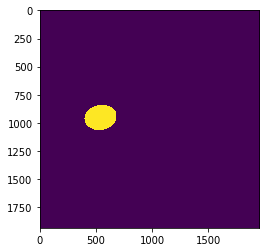

 51%|█████     | 135/265 [00:36<00:35,  3.68it/s]

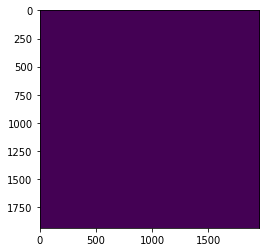

 51%|█████▏    | 136/265 [00:37<00:35,  3.65it/s]

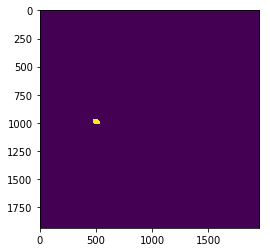

 52%|█████▏    | 137/265 [00:37<00:35,  3.65it/s]

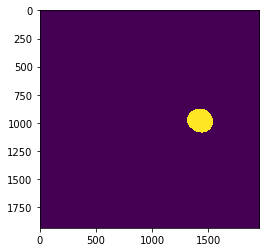

 52%|█████▏    | 138/265 [00:37<00:34,  3.66it/s]

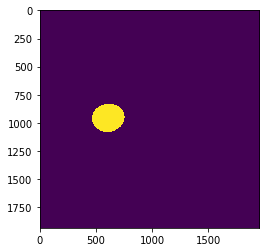

 52%|█████▏    | 139/265 [00:38<00:34,  3.66it/s]

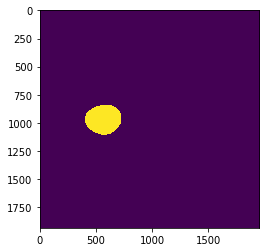

 53%|█████▎    | 140/265 [00:38<00:34,  3.66it/s]

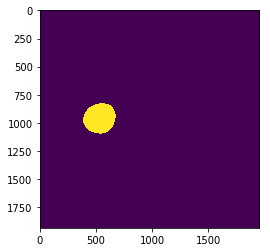

 53%|█████▎    | 141/265 [00:38<00:33,  3.66it/s]

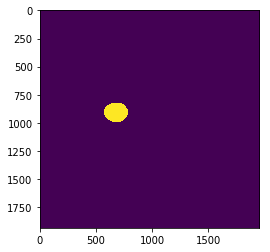

 54%|█████▎    | 142/265 [00:38<00:33,  3.66it/s]

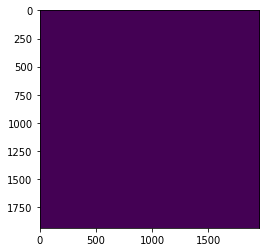

 54%|█████▍    | 143/265 [00:39<00:33,  3.66it/s]

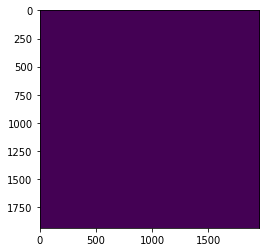

 54%|█████▍    | 144/265 [00:39<00:33,  3.66it/s]

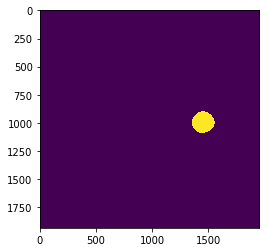

 55%|█████▍    | 145/265 [00:39<00:32,  3.66it/s]

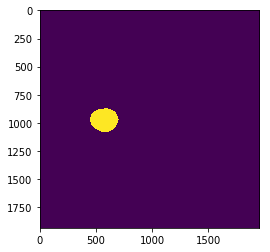

 55%|█████▌    | 146/265 [00:39<00:32,  3.66it/s]

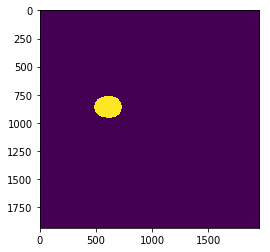

 55%|█████▌    | 147/265 [00:40<00:32,  3.66it/s]

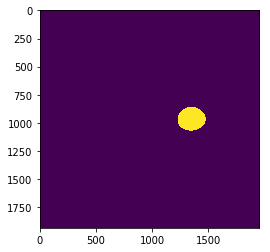

 56%|█████▌    | 148/265 [00:40<00:31,  3.66it/s]

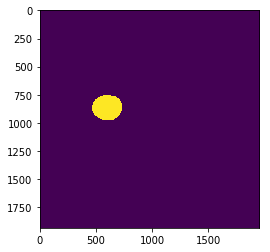

 56%|█████▌    | 149/265 [00:40<00:31,  3.67it/s]

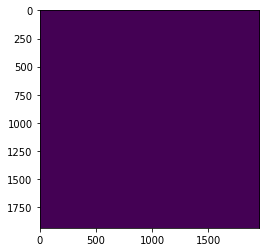

 57%|█████▋    | 150/265 [00:40<00:31,  3.67it/s]

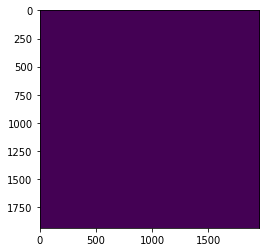

 57%|█████▋    | 151/265 [00:41<00:31,  3.66it/s]

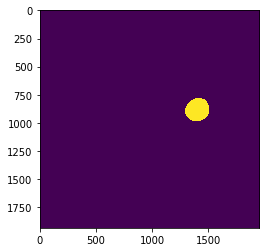

 57%|█████▋    | 152/265 [00:41<00:30,  3.67it/s]

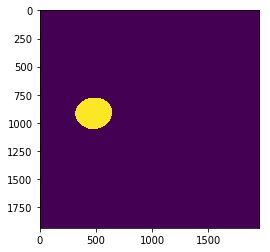

 58%|█████▊    | 153/265 [00:41<00:30,  3.67it/s]

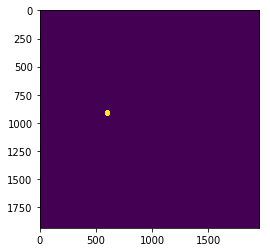

 58%|█████▊    | 154/265 [00:41<00:30,  3.67it/s]

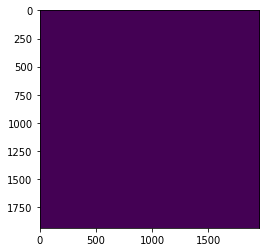

 58%|█████▊    | 155/265 [00:42<00:29,  3.67it/s]

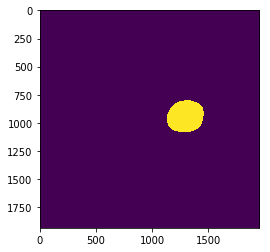

 59%|█████▉    | 156/265 [00:42<00:29,  3.67it/s]

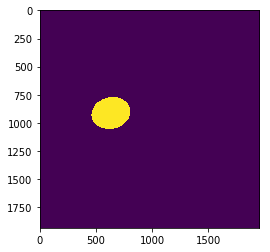

 59%|█████▉    | 157/265 [00:42<00:29,  3.67it/s]

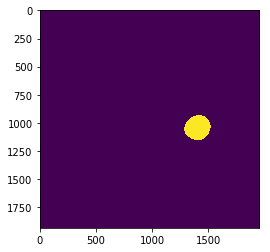

 60%|█████▉    | 158/265 [00:43<00:29,  3.67it/s]

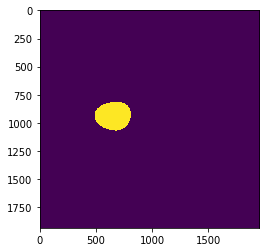

 60%|██████    | 159/265 [00:43<00:28,  3.67it/s]

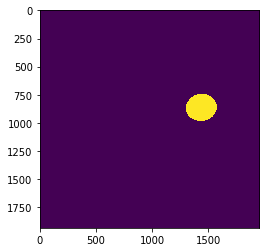

 60%|██████    | 160/265 [00:43<00:28,  3.68it/s]

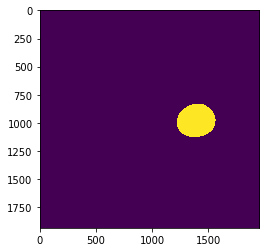

 61%|██████    | 161/265 [00:43<00:28,  3.68it/s]

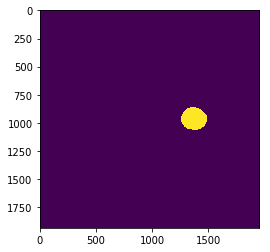

 61%|██████    | 162/265 [00:44<00:28,  3.68it/s]

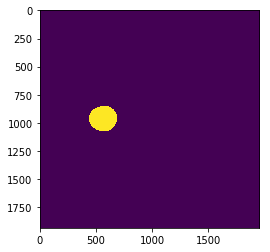

 62%|██████▏   | 163/265 [00:44<00:27,  3.68it/s]

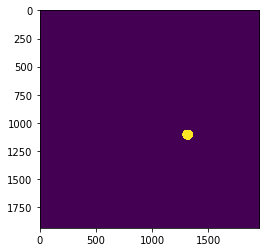

 62%|██████▏   | 164/265 [00:44<00:27,  3.68it/s]

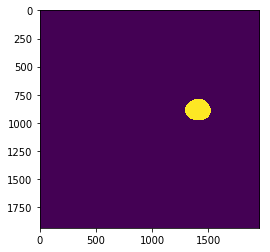

 62%|██████▏   | 165/265 [00:44<00:27,  3.68it/s]

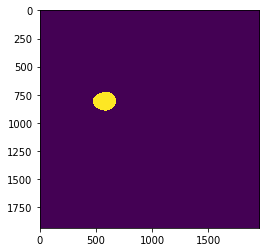

 63%|██████▎   | 166/265 [00:45<00:26,  3.68it/s]

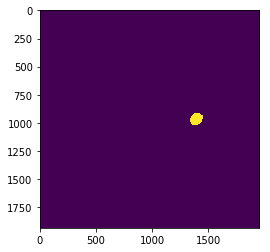

 63%|██████▎   | 167/265 [00:45<00:26,  3.68it/s]

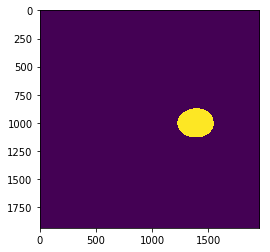

 63%|██████▎   | 168/265 [00:45<00:26,  3.69it/s]

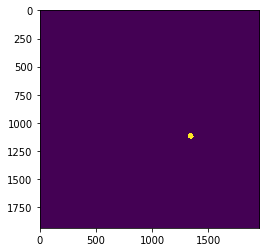

 64%|██████▍   | 169/265 [00:45<00:26,  3.69it/s]

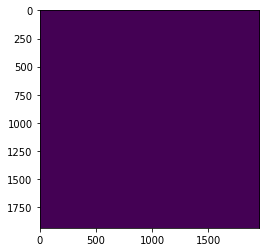

 64%|██████▍   | 170/265 [00:46<00:25,  3.69it/s]

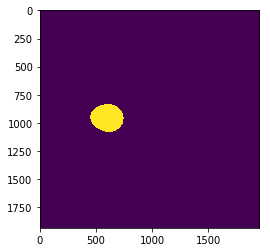

 65%|██████▍   | 171/265 [00:46<00:25,  3.69it/s]

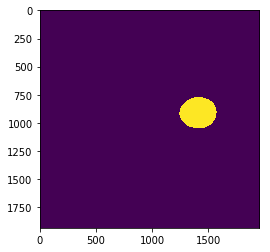

 65%|██████▍   | 172/265 [00:46<00:25,  3.69it/s]

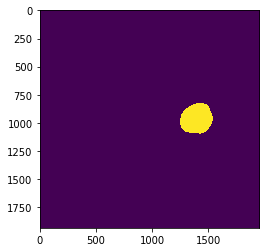

 65%|██████▌   | 173/265 [00:46<00:24,  3.69it/s]

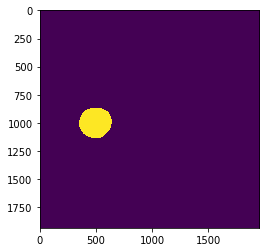

 66%|██████▌   | 174/265 [00:47<00:24,  3.69it/s]

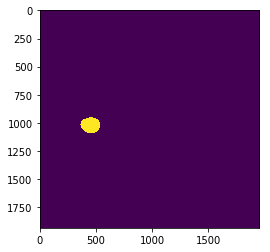

 66%|██████▌   | 175/265 [00:47<00:24,  3.69it/s]

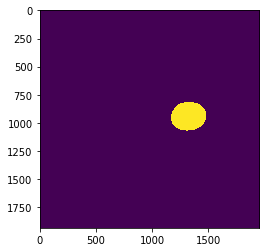

 66%|██████▋   | 176/265 [00:47<00:24,  3.69it/s]

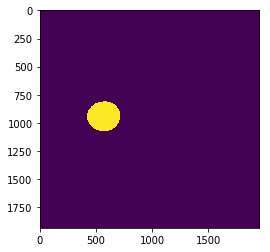

 67%|██████▋   | 177/265 [00:47<00:23,  3.70it/s]

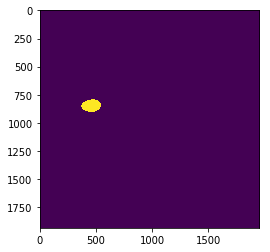

 67%|██████▋   | 178/265 [00:48<00:23,  3.70it/s]

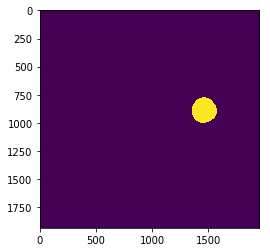

 68%|██████▊   | 179/265 [00:48<00:23,  3.70it/s]

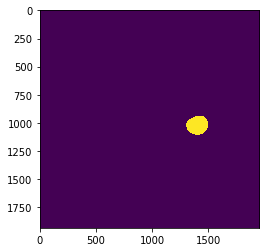

 68%|██████▊   | 180/265 [00:48<00:22,  3.70it/s]

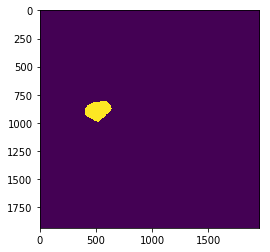

 68%|██████▊   | 181/265 [00:48<00:22,  3.70it/s]

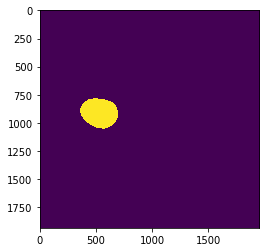

 69%|██████▊   | 182/265 [00:49<00:22,  3.70it/s]

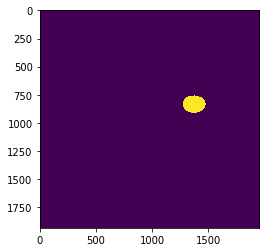

 69%|██████▉   | 183/265 [00:49<00:22,  3.70it/s]

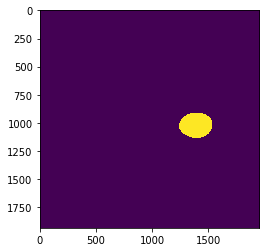

 69%|██████▉   | 184/265 [00:49<00:21,  3.70it/s]

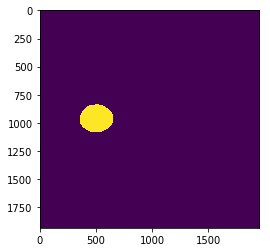

 70%|██████▉   | 185/265 [00:49<00:21,  3.70it/s]

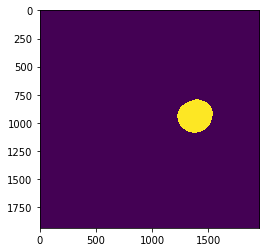

 70%|███████   | 186/265 [00:50<00:21,  3.71it/s]

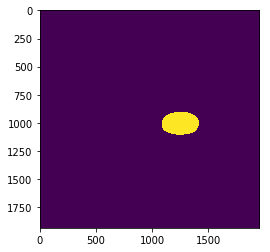

 71%|███████   | 187/265 [00:50<00:21,  3.71it/s]

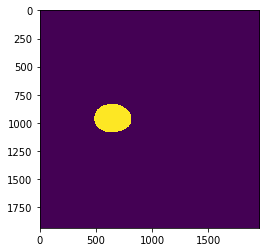

 71%|███████   | 188/265 [00:50<00:20,  3.71it/s]

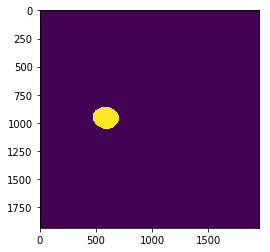

 71%|███████▏  | 189/265 [00:50<00:20,  3.71it/s]

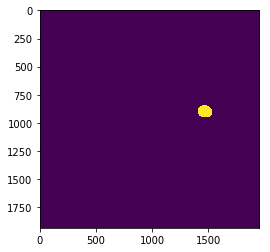

 72%|███████▏  | 190/265 [00:51<00:20,  3.71it/s]

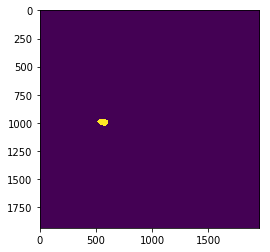

 72%|███████▏  | 191/265 [00:51<00:19,  3.71it/s]

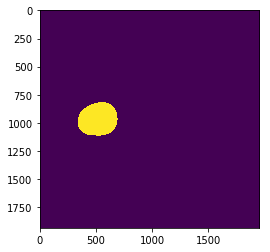

 72%|███████▏  | 192/265 [00:51<00:19,  3.71it/s]

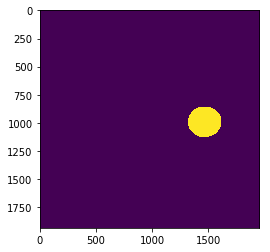

 73%|███████▎  | 193/265 [00:52<00:19,  3.71it/s]

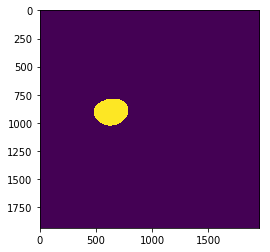

 73%|███████▎  | 194/265 [00:52<00:19,  3.71it/s]

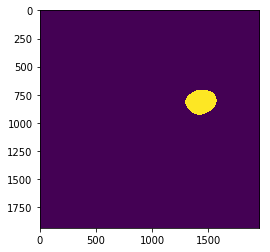

 74%|███████▎  | 195/265 [00:52<00:18,  3.71it/s]

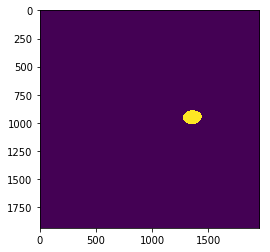

 74%|███████▍  | 196/265 [00:52<00:18,  3.71it/s]

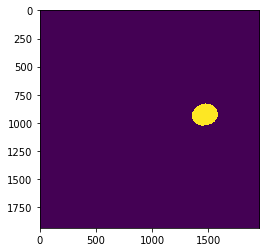

 74%|███████▍  | 197/265 [00:53<00:18,  3.71it/s]

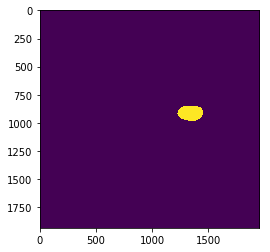

 75%|███████▍  | 198/265 [00:53<00:18,  3.71it/s]

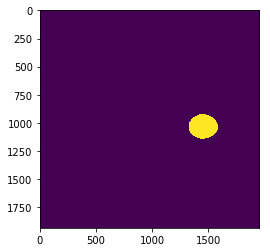

 75%|███████▌  | 199/265 [00:53<00:17,  3.71it/s]

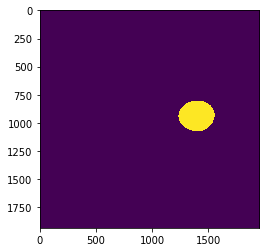

 75%|███████▌  | 200/265 [00:53<00:17,  3.72it/s]

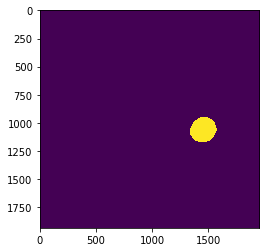

 76%|███████▌  | 201/265 [00:54<00:17,  3.72it/s]

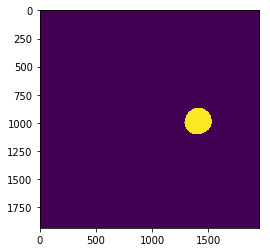

 76%|███████▌  | 202/265 [00:54<00:16,  3.72it/s]

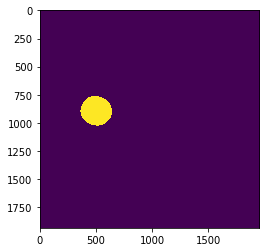

 77%|███████▋  | 203/265 [00:54<00:16,  3.72it/s]

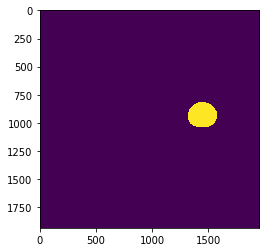

 77%|███████▋  | 204/265 [00:54<00:16,  3.72it/s]

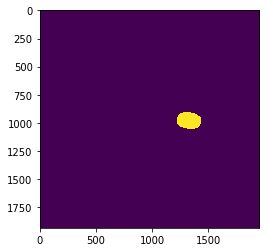

 77%|███████▋  | 205/265 [00:55<00:16,  3.72it/s]

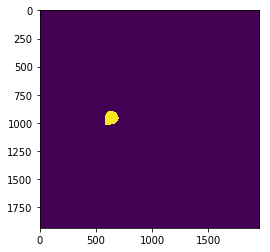

 78%|███████▊  | 206/265 [00:55<00:15,  3.72it/s]

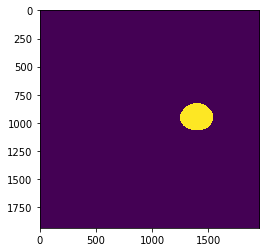

 78%|███████▊  | 207/265 [00:55<00:15,  3.72it/s]

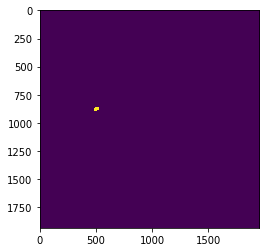

 78%|███████▊  | 208/265 [00:55<00:15,  3.72it/s]

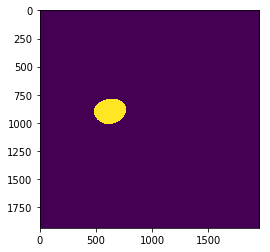

 79%|███████▉  | 209/265 [00:56<00:15,  3.71it/s]

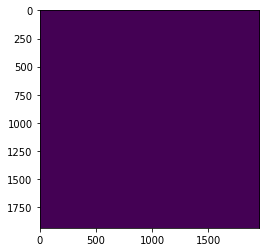

 79%|███████▉  | 210/265 [00:56<00:14,  3.71it/s]

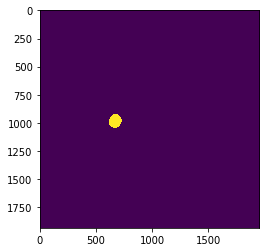

 80%|███████▉  | 211/265 [00:56<00:14,  3.71it/s]

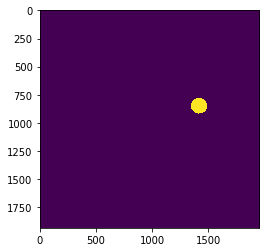

 80%|████████  | 212/265 [00:57<00:14,  3.71it/s]

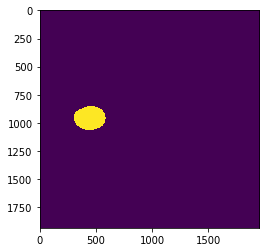

 80%|████████  | 213/265 [00:57<00:14,  3.71it/s]

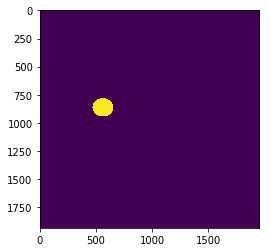

 81%|████████  | 214/265 [00:57<00:13,  3.71it/s]

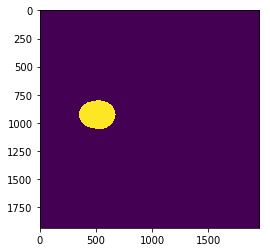

 81%|████████  | 215/265 [00:57<00:13,  3.71it/s]

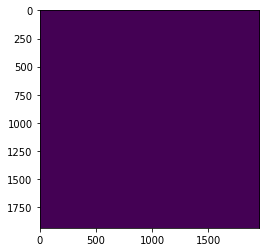

 82%|████████▏ | 216/265 [00:58<00:13,  3.71it/s]

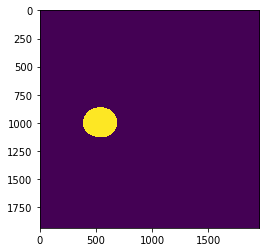

 82%|████████▏ | 217/265 [00:58<00:12,  3.71it/s]

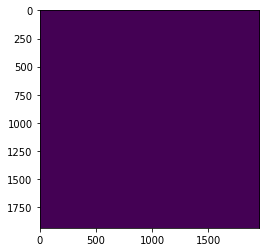

 82%|████████▏ | 218/265 [00:58<00:12,  3.71it/s]

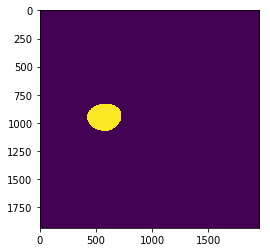

 83%|████████▎ | 219/265 [00:59<00:12,  3.71it/s]

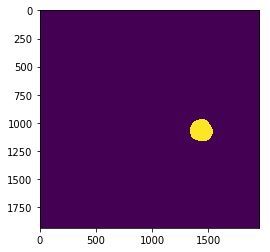

 83%|████████▎ | 220/265 [00:59<00:12,  3.71it/s]

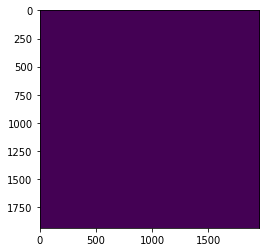

 83%|████████▎ | 221/265 [00:59<00:11,  3.71it/s]

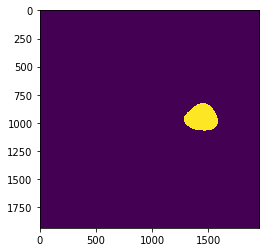

 84%|████████▍ | 222/265 [00:59<00:11,  3.71it/s]

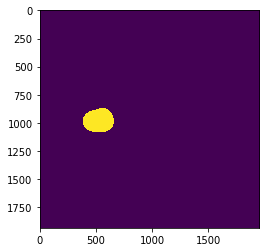

 84%|████████▍ | 223/265 [01:00<00:11,  3.71it/s]

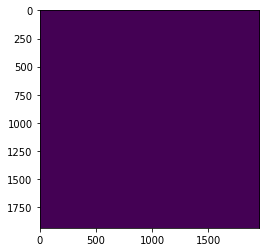

 85%|████████▍ | 224/265 [01:00<00:11,  3.71it/s]

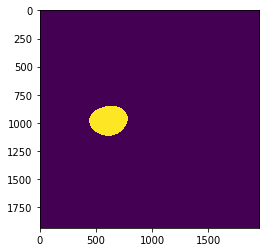

 85%|████████▍ | 225/265 [01:00<00:10,  3.72it/s]

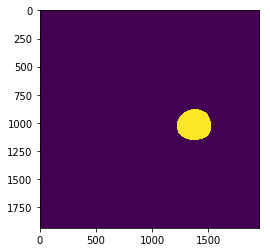

 85%|████████▌ | 226/265 [01:00<00:10,  3.72it/s]

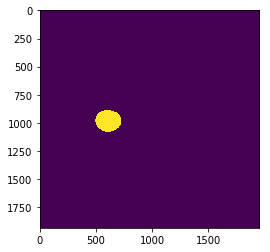

 86%|████████▌ | 227/265 [01:01<00:10,  3.72it/s]

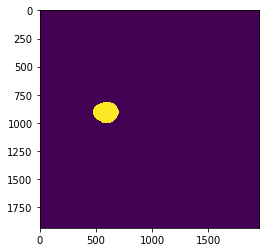

 86%|████████▌ | 228/265 [01:01<00:09,  3.72it/s]

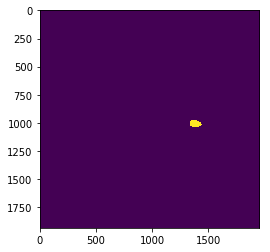

 86%|████████▋ | 229/265 [01:01<00:09,  3.72it/s]

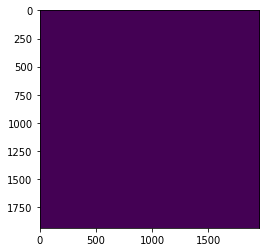

 87%|████████▋ | 230/265 [01:01<00:09,  3.72it/s]

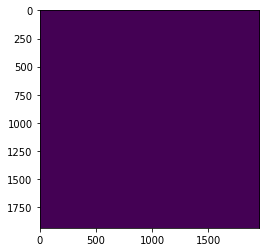

 87%|████████▋ | 231/265 [01:02<00:09,  3.72it/s]

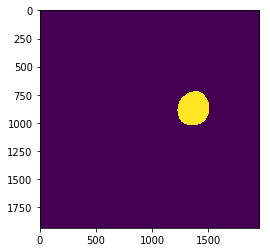

 88%|████████▊ | 232/265 [01:02<00:08,  3.72it/s]

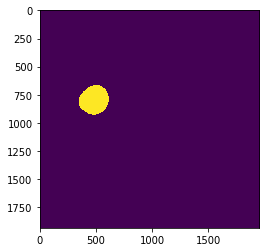

 88%|████████▊ | 233/265 [01:02<00:08,  3.72it/s]

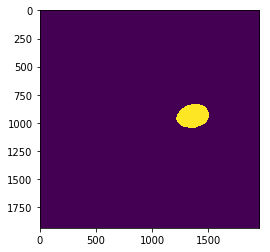

 88%|████████▊ | 234/265 [01:02<00:08,  3.72it/s]

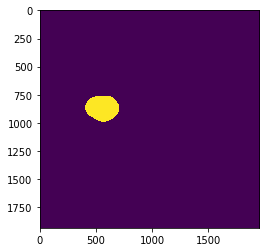

 89%|████████▊ | 235/265 [01:03<00:08,  3.72it/s]

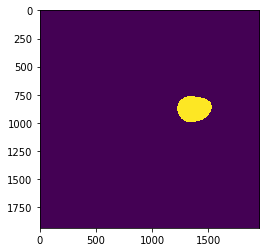

 89%|████████▉ | 236/265 [01:03<00:07,  3.72it/s]

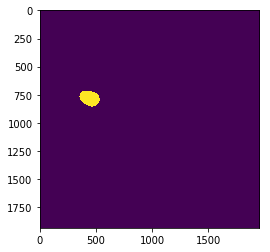

 89%|████████▉ | 237/265 [01:03<00:07,  3.72it/s]

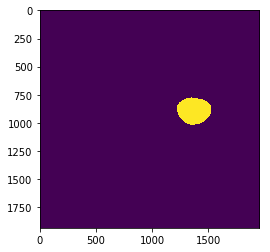

 90%|████████▉ | 238/265 [01:03<00:07,  3.72it/s]

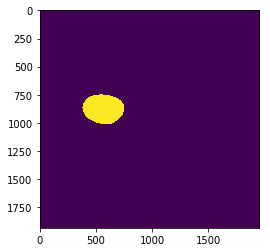

 90%|█████████ | 239/265 [01:04<00:06,  3.72it/s]

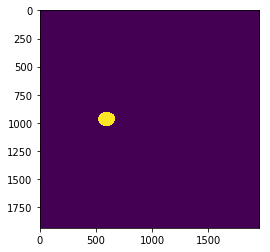

 91%|█████████ | 240/265 [01:04<00:06,  3.72it/s]

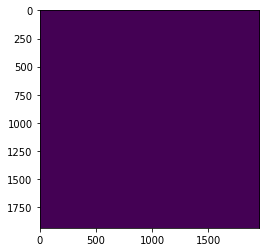

 91%|█████████ | 241/265 [01:04<00:06,  3.72it/s]

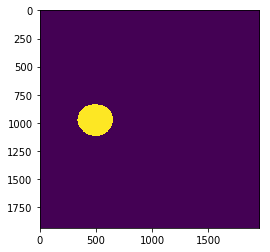

 91%|█████████▏| 242/265 [01:04<00:06,  3.73it/s]

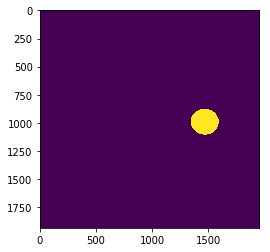

 92%|█████████▏| 243/265 [01:05<00:05,  3.73it/s]

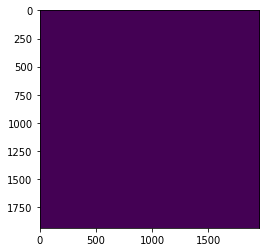

 92%|█████████▏| 244/265 [01:05<00:05,  3.73it/s]

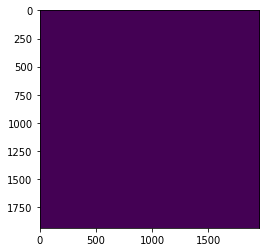

 92%|█████████▏| 245/265 [01:05<00:05,  3.73it/s]

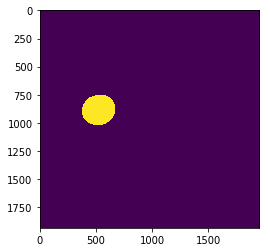

 93%|█████████▎| 246/265 [01:05<00:05,  3.73it/s]

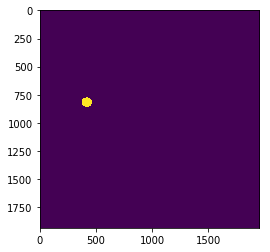

 93%|█████████▎| 247/265 [01:06<00:04,  3.73it/s]

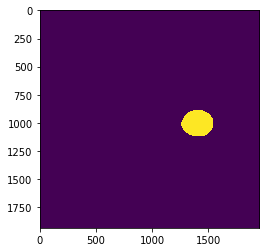

 94%|█████████▎| 248/265 [01:06<00:04,  3.73it/s]

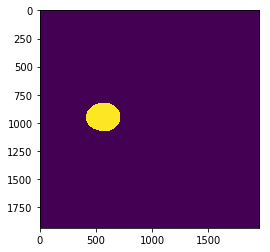

 94%|█████████▍| 249/265 [01:06<00:04,  3.73it/s]

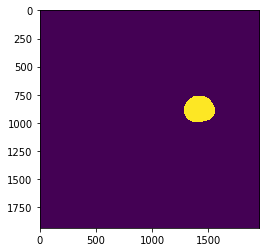

 94%|█████████▍| 250/265 [01:07<00:04,  3.73it/s]

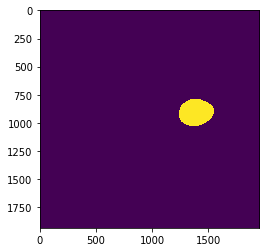

 95%|█████████▍| 251/265 [01:07<00:03,  3.73it/s]

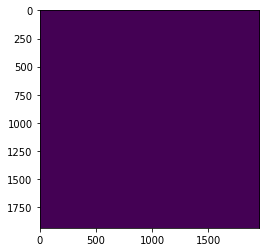

 95%|█████████▌| 252/265 [01:07<00:03,  3.73it/s]

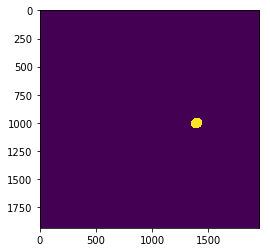

 95%|█████████▌| 253/265 [01:07<00:03,  3.73it/s]

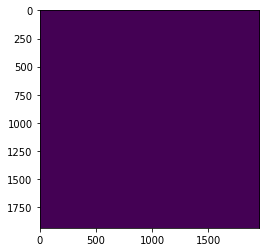

 96%|█████████▌| 254/265 [01:08<00:02,  3.73it/s]

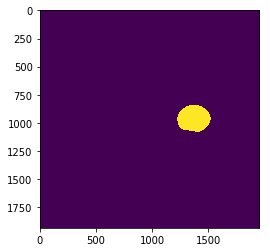

 96%|█████████▌| 255/265 [01:08<00:02,  3.73it/s]

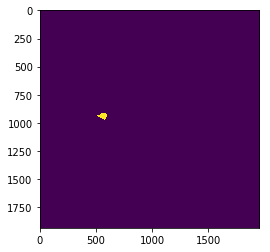

 97%|█████████▋| 256/265 [01:08<00:02,  3.73it/s]

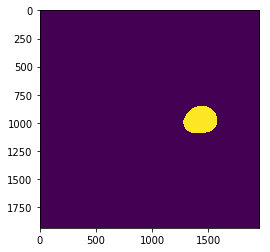

 97%|█████████▋| 257/265 [01:08<00:02,  3.73it/s]

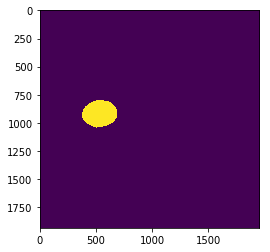

 97%|█████████▋| 258/265 [01:09<00:01,  3.73it/s]

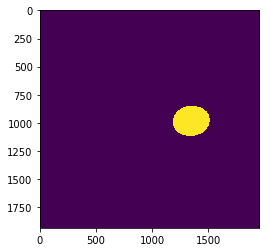

 98%|█████████▊| 259/265 [01:09<00:01,  3.73it/s]

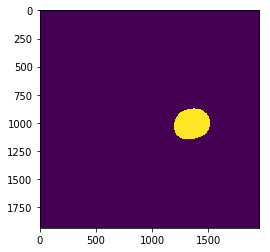

 98%|█████████▊| 260/265 [01:09<00:01,  3.73it/s]

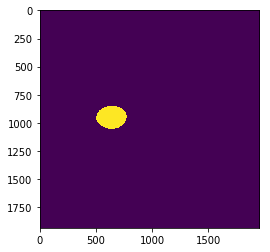

 98%|█████████▊| 261/265 [01:10<00:01,  3.73it/s]

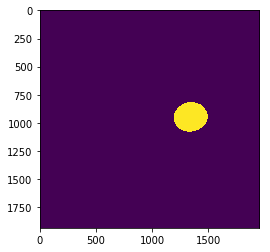

 99%|█████████▉| 262/265 [01:10<00:00,  3.73it/s]

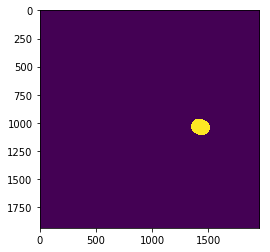

 99%|█████████▉| 263/265 [01:10<00:00,  3.73it/s]

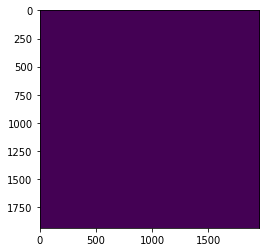

100%|█████████▉| 264/265 [01:10<00:00,  3.73it/s]

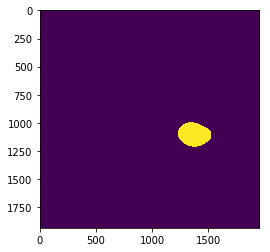

100%|██████████| 265/265 [01:11<00:00,  3.73it/s]


In [25]:
print('Predicting on {} samples with batch_size = {}...'.format(len(ids_test), val_batch_size))
for start in tqdm(range(0, len(ids_test), val_batch_size)):
    x_batch = []
    end = min(start + val_batch_size, len(ids_test))
    ids_test_batch = ids_test[start:end]
    for id in ids_test_batch.values:
        img = cv2.imread('data2/data/test/test/{}.jpg'.format(id))
        orig_width = np.shape(img)[1]
        orig_height = np.shape(img)[0]
        img = cv2.resize(img, (input_size, input_size))
        x_batch.append(img)
    x_batch = np.array(x_batch, np.float32) / 255
    preds = model.predict_on_batch(x_batch)
    for pred in preds:
        prob = cv2.resize(pred, (orig_width, orig_height))
        mask = prob > threshold
        mask = mask*255
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.imshow(mask)
        plt.show()
        cv2.imwrite('data2/data/DL_masksZF_unet/{}.png'.format(id),mask)